In [ ]:
import random
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.functional as F
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, models

import os
import cv2
import pickle
from PIL import Image
import PIL
import requests
from io import BytesIO
import shutil
import pathlib

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/f.zip' &> /dev/null

In [ ]:
data_dir = 'dataset'
train_dir = 'train'
val_dir = 'val'

In [ ]:
os.mkdir(train_dir)
os.mkdir(val_dir)

In [ ]:
# хочется посмотреть сколько файлов в каждом классе изначально
# объявляем функцию реализующую данный подсчет
def get_n_files(directory):
    df = pd.DataFrame()
    df['classes'] = os.listdir(data_dir)
    n_files = np.array([], dtype=np.int32)
    for class_name in os.listdir(data_dir):
        source_dir = os.path.join(directory, class_name)
        n_files = np.append(n_files, len(os.listdir(source_dir)))
    df['n_files'] = n_files
    return df

overall_df = get_n_files(data_dir).sort_values(by='classes', ignore_index=True)
print(overall_df)

                 classes  n_files
0                 bridge      278
1                  camel      292
2                  chair      200
3   chaturanga_dandasana      259
4                 childs       77
5                  cobra      281
6                    cow      200
7         crescent_lunge      200
8            downwarddog      123
9              half_moon      202
10              mountain      219
11                 plank      374
12     seatedforwardbend       73
13                  tree      307
14              triangle      287
15             warrior_I      265
16            warrior_II      272
17           warrior_III      200


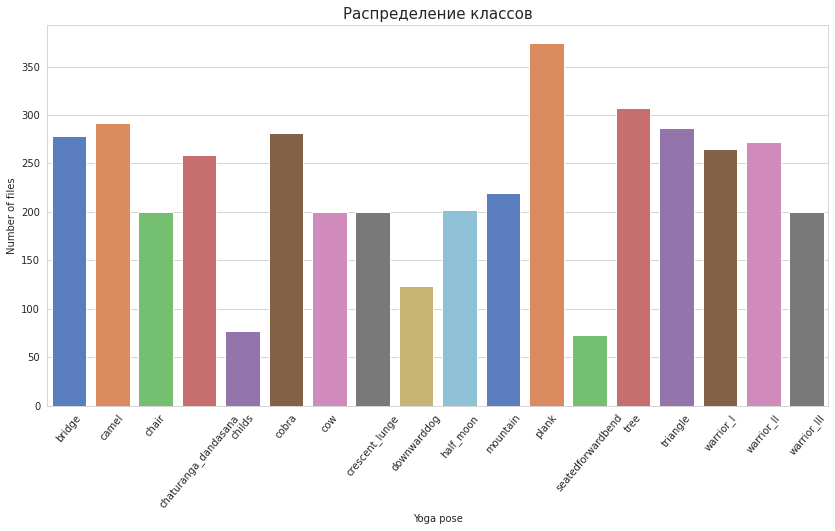

In [ ]:
sns.set_style("whitegrid")
bar, ax = plt.subplots(figsize=(14,7))
ax = sns.barplot(x=overall_df.classes, y=overall_df.n_files, data=overall_df, ci=None, palette="muted",orient='v', )
ax.set_title("Распределение классов", fontsize=15)
ax.set_xlabel ("Yoga pose")
ax.set_ylabel ("Number of files")
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
None

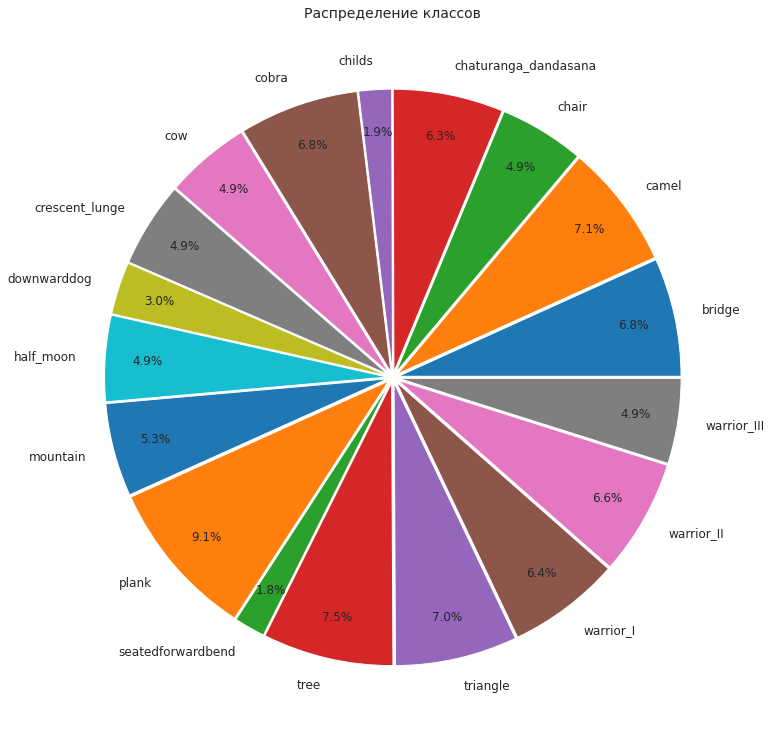

In [ ]:
pie, ax = plt.subplots(figsize=[15,13])
labels = overall_df['classes']
plt.pie(x=overall_df['n_files'], autopct="%.1f%%", explode=[0.02]*18,
          labels=labels, pctdistance=0.85, textprops={'fontsize': 12})
plt.title("Распределение классов", fontsize=14);

In [ ]:
# разделим датасет на train, val, test части 
# а каждая 10-ая - в val
for class_name in os.listdir(data_dir):
    source_dir = os.path.join(data_dir, class_name)
    os.mkdir(os.path.join(train_dir, class_name))
    os.mkdir(os.path.join(val_dir, class_name))
    for i, file_name in enumerate(os.listdir(source_dir)):
        if os.stat(os.path.join(source_dir, file_name)).st_size == 0:
            continue
        if i % 10 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

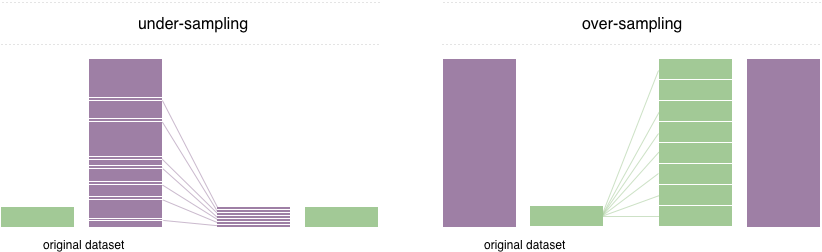

In [ ]:
# видим что где-то картинок совсем мало
# применим подход под названием OverSampling:
# он заключается в том, чтобы докопировать количество картинок из меньших классов,
# так, чтобы общее число картинок было таким же как и у классов с большим числом картинок.
# с учетом аугментаций эти картинки будут различны 
# и так мы решим проблему несбалансированности классов
def generate_data(directory):
    temp_train_df = get_n_files(directory)
    few_names = temp_train_df[temp_train_df['n_files'] < 150]['classes'].values
    generated = 0
    for class_name in few_names:
        source_dir = os.path.join(directory, class_name)
        files = os.listdir(source_dir)
        index = 10
        while True:
            leave = False
            for file in files:
                image = cv2.imread(os.path.join(source_dir, file))
                image_name = os.path.join(source_dir, str(index) + '_' + str(generated) +'d.jpg')
                if not os.path.exists(image_name):
                    cv2.imwrite(image_name, image)
                generated += 1
                if generated % 100 == 0:
                    print('Succesfully generated {} images'.format(generated))
                # check if its time to leave
                if(len(os.listdir(source_dir)) > 149):
                    leave = True
                    break
            index += 1
            if leave:
                break
    print('Total generated {} images'.format(generated))
    return None

In [ ]:
generate_data(train_dir)

Succesfully generated 100 images
Succesfully generated 200 images
Total generated 206 images


In [ ]:
print(get_n_files(train_dir).sort_values(by='classes', ignore_index=True))

                 classes  n_files
0                 bridge      250
1                  camel      262
2                  chair      180
3   chaturanga_dandasana      233
4                 childs      150
5                  cobra      252
6                    cow      180
7         crescent_lunge      180
8            downwarddog      150
9              half_moon      181
10              mountain      197
11                 plank      336
12     seatedforwardbend      150
13                  tree      276
14              triangle      258
15             warrior_I      238
16            warrior_II      244
17           warrior_III      180


In [ ]:
dirs = [train_dir, val_dir]
for dir in dirs:
    cpt = sum([len(files) for r, d, files in os.walk(dir)])
    print('Number of files in {} --- {}'.format(dir, cpt))

Number of files in train --- 3897
Number of files in val --- 418


# Dataset and augmentations

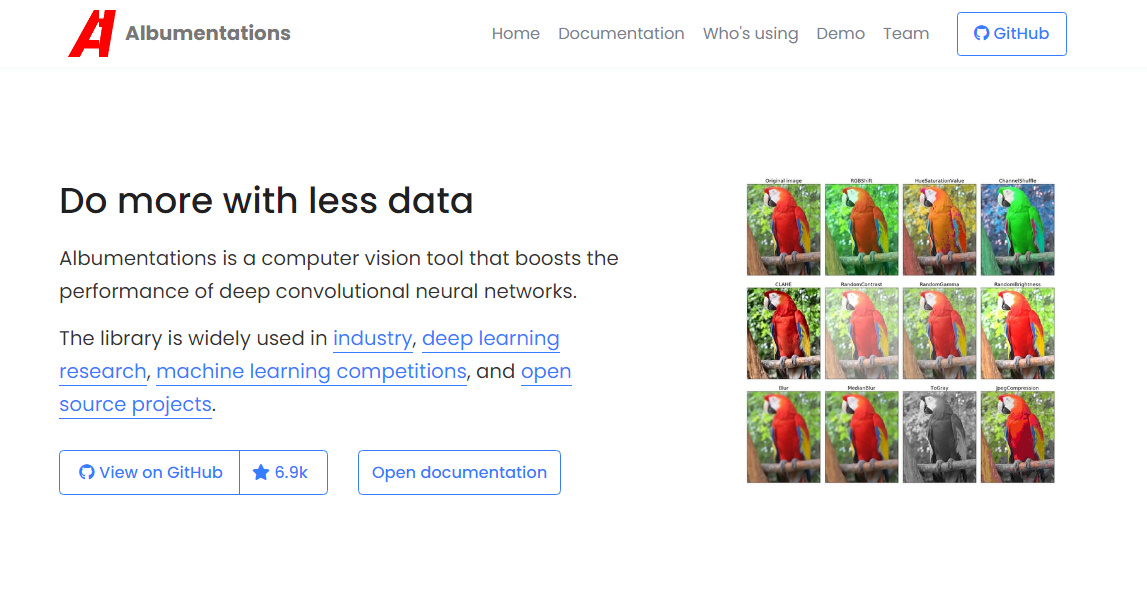

In [ ]:
# используем хороший модуль albu для аугментации картинок
# она предоставляет мощный и простой в использовании функционал
!pip install albumentations &> /dev/null

In [ ]:
# для train возьмем две трансформации, различающиеся только в Image-Crop`ом
# для примененных функций многие названия говорят сами за себя
import albumentations as A
from albumentations.pytorch import ToTensor

IMAGE_SIZE = 331
train_transform_1 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=25, p=0.5),
    A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE),
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
    A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=15, val_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0),
    A.Cutout(p=0.5),
    ToTensor(),
])
train_transform_2 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=25, p=0.5),
    A.Resize(height=600, width=600),
    A.CenterCrop(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
    A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=15, val_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0),
    A.Cutout(p=0.5),
    ToTensor(),
])
# простая трансформация для валидационной выборки
val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE+150, width=IMAGE_SIZE+150),
    A.CenterCrop(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0),
    ToTensor(),
])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
modes = ['train', 'val']

# датасет подгружающий картинки
# и проводящий аугментацию
class YogaDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = files
        self.mode = mode

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)

        with open('label_encoder.pkl', 'wb') as le_dump_file:
              pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        single_image_path = self.files[index]
        image = Image.open(single_image_path)
        image = np.array(image)
        if np.ndim(image) == 2: # разберемся с двухканальными 
            image = cv2.merge((image,image,image))
        if image.shape[2] == 4: # а так же четрыехканальными изображениями
                                # приведя их всех к RGB формату
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
        image = self._prepare_sample(image)

        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return image, y
        
    def _prepare_sample(self, image):
        if self.mode == 'train':
            random_value = random.random()
            if random_value < 0.5:
                image = train_transform_1(image=image)['image']
            else:
                image = train_transform_2(image=image)['image']
        else:
            image = val_transform(image=image)['image']
        return image

In [ ]:
TRAIN_dir = pathlib.Path(train_dir)            # train папка 
VAL_dir = pathlib.Path(val_dir)                # val
ALL_dir = pathlib.Path(data_dir)

train_files = sorted(list(TRAIN_dir.rglob('*.jpg')))
val_files = sorted(list(VAL_dir.rglob('*.jpg')))
all_files = sorted(list(ALL_dir.rglob('*.jpg')))

In [ ]:
# для каждого объявим соответствующий датасет
train_dataset = YogaDataset(train_files, 'train')
val_dataset = YogaDataset(val_files, 'val')
all_dataset = YogaDataset(all_files, 'train')

In [ ]:
# посмотрим на длину каждого их них
len(train_dataset), len(val_dataset), len(all_dataset)

(3897, 418, 4109)

In [ ]:
# количество различных классов
num_classes = len(train_dataset.label_encoder.classes_)

In [ ]:
std = [0.485, 0.456, 0.406]
mean = [0.229, 0.224, 0.225]

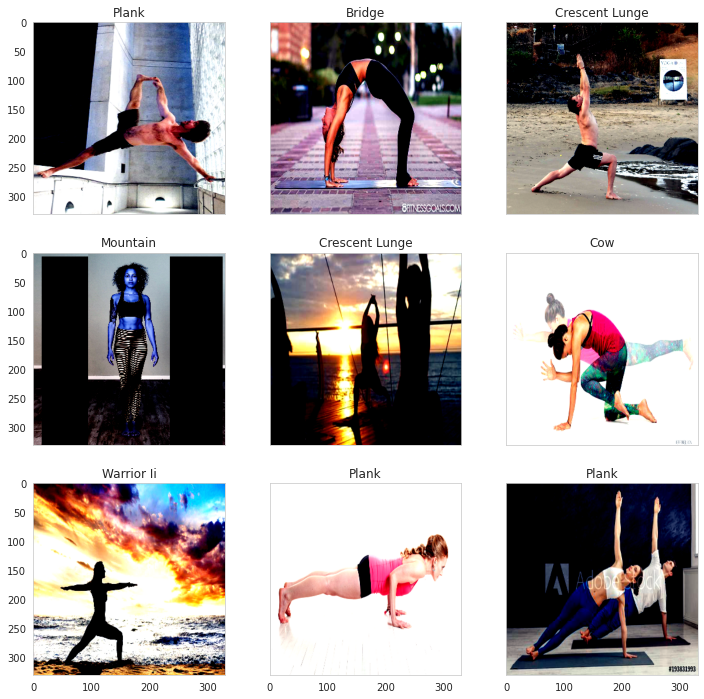

In [ ]:
# посмотрим на наших героев и убедимся что все работает как должно
sns.set_style("whitegrid", {'axes.grid' : False})
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,12), \
                       sharex=True, sharey=True)
for ax in axs.flatten():
    random_image = int(np.random.uniform(0,len(val_dataset)))
    im_val, label = val_dataset[random_image]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    ax.set_title(img_label)
    image = np.clip(im_val.permute(1, 2, 0).numpy()*std + mean, 0, 1)
    ax.imshow(image)
plt.show()

In [ ]:
# объявим dataloader`ы и batch_size
# так как мы при fine_tuning`е учим не только финальный classifier - слой
# но и некоторую часть конволюционных слоев, то лучше выбрать batch_size поменьше
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
all_dataloader = torch.utils.data.DataLoader(
    all_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)

# Model selection and Training

In [ ]:
def train_model(model, loss, optimizer, scheduler, scaler, num_epochs, cosine=False, train_all=False):

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    accum_iter = 2

    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        phases = ['train']
        if not train_all:
            phases += ['val']
        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                if train_all:
                    dataloader = all_dataloader
                else:
                    dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for step, (inputs, labels) in enumerate(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward and backward
                with autocast():
                    with torch.set_grad_enabled(phase == 'train'):
                        preds = model(inputs)
                        loss_value = loss(preds, labels)

                        preds_class = preds.argmax(dim=1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            if cosine and (((step + 1) %  accum_iter == 0) or \
                                              ((step + 1) == len(dataloader))):
                                scaler.scale(loss_value).backward()
                                scaler.step(optimizer)
                                scaler.update()
                                optimizer.zero_grad()
                                scheduler.step()
                            else:
                                loss_value.backward()
                                optimizer.step()
                                optimizer.zero_grad()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                scheduler.step()
                train_accuracy.append(epoch_acc)
                train_loss.append(epoch_loss)
            else:
                
                val_accuracy.append(epoch_acc)
                val_loss.append(epoch_loss)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return train_accuracy, train_loss, val_accuracy, val_loss

In [ ]:
!pip install pytorchcv &> /dev/null

In [ ]:
from pytorchcv.model_provider import get_model as ptcv_get_model
class MyPNASNET(nn.Module):
    def __init__(self):
        super(MyPNASNET, self).__init__()
        self.model = ptcv_get_model("pnasnet5large", pretrained=True)

        # заморозим начальные слои модели, чтобы не потерять полученные
        # при обучении на ImageNet признаки
        for i, child in enumerate(self.model.features.children()):
            if i < 4:
                for param in child.parameters():
                    param.requires_grad = False

        # подправим выходной слой
        self.model.output.fc = nn.Linear(4320, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = MyPNASNET()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3.0e-4, amsgrad=True)

In [ ]:
import math
"""
Подберем оптимальный learning rate.
Суть подхода заключается в том, чтобы обучать нейросеть на каждом батче 
с различным уровнем lr, начиная с самого малого в выбранном нами 
диапазоне и заканчивая самым большим.  При этом мы будем записывать в 
массив значение lr и полученного на этом значении loss функции.
"""
init_value=3.0e-6
final_value=0.1
model.train()
number_in_epoch = len(train_dataloader) - 1
update_step = (final_value / init_value) ** (1 / number_in_epoch)
lr = init_value
optimizer.param_groups[0]["lr"] = lr
best_loss = 0.0
batch_num = 0
losses = []
log_lrs = []
for inputs, labels in tqdm(train_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    batch_num += 1
    optimizer.zero_grad()
    outputs = model(inputs)
    loss_fn = loss(outputs, labels)

    # Crash out if loss explodes

    if batch_num > 1 and loss_fn > 5 * best_loss:
        break

    # Record the best loss

    if loss_fn < best_loss or batch_num == 1:
        best_loss = loss_fn

    # Store the values

    losses.append(loss_fn)
    log_lrs.append(math.log10(lr))

    # Do the backward pass and optimize

    loss_fn.backward()
    optimizer.step()

    # Update the lr for the next step and store

    lr *= update_step
    optimizer.param_groups[0]["lr"] = lr


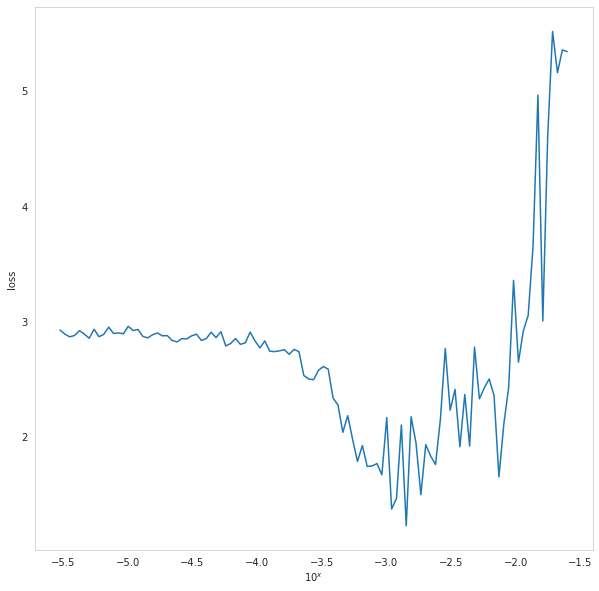

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(log_lrs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")
None

In [ ]:
del model, loss, optimizer
torch.cuda.empty_cache()

In [ ]:
# https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

# smooth your target by replacing 0 by eps/(n_classes-1) and target 1 by 1 - eps.

class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth_one_hot(targets:torch.Tensor, n_classes:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = torch.empty(size=(targets.size(0), n_classes),
                    device=targets.device) \
                .fill_(smoothing /(n_classes-1)) \
                .scatter_(1, targets.data.unsqueeze(1), 1.-smoothing)
        return targets

    def forward(self, inputs, targets):
        targets = SmoothCrossEntropyLoss._smooth_one_hot(targets, inputs.size(-1),
            self.smoothing)
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [ ]:
model = MyPNASNET()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

scaler = GradScaler()
loss = SmoothCrossEntropyLoss(smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=2.0e-4, amsgrad=True)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=3.0e-7, last_epoch=-1)

In [ ]:
seed_all(31)

history = train_model(model, loss, optimizer, scheduler, scaler, num_epochs=12, cosine=True)

Epoch 0/11:
train Loss: 2.0092 Acc: 0.4576
val Loss: 1.1354 Acc: 0.7946
Epoch 1/11:
train Loss: 1.2280 Acc: 0.7603
val Loss: 0.9802 Acc: 0.8482
Epoch 2/11:
train Loss: 0.9994 Acc: 0.8551
val Loss: 0.9202 Acc: 0.8638
Epoch 3/11:
train Loss: 0.8949 Acc: 0.8975
val Loss: 0.9243 Acc: 0.8884
Epoch 4/11:
train Loss: 0.8225 Acc: 0.9277
val Loss: 0.9487 Acc: 0.8616
Epoch 5/11:
train Loss: 0.7799 Acc: 0.9432
val Loss: 0.9384 Acc: 0.8728
Epoch 6/11:
train Loss: 0.7597 Acc: 0.9507
val Loss: 0.9204 Acc: 0.8705
Epoch 7/11:
train Loss: 0.7373 Acc: 0.9574
val Loss: 0.9179 Acc: 0.8973
Epoch 8/11:
train Loss: 0.7118 Acc: 0.9677
val Loss: 0.9902 Acc: 0.8638
Epoch 9/11:
train Loss: 0.7210 Acc: 0.9623
val Loss: 0.9528 Acc: 0.8862
Epoch 10/11:
train Loss: 0.7031 Acc: 0.9675
val Loss: 1.0015 Acc: 0.8772
Epoch 11/11:
train Loss: 0.6849 Acc: 0.9778
val Loss: 0.9430 Acc: 0.8817


In [ ]:
torch.save(model.state_dict(), "drive/MyDrive/pnasnet_011_weights.pth")
# model.load_state_dict(torch.load('drive/MyDrive/pnasnet_001_weights.pth'))
# model.eval()

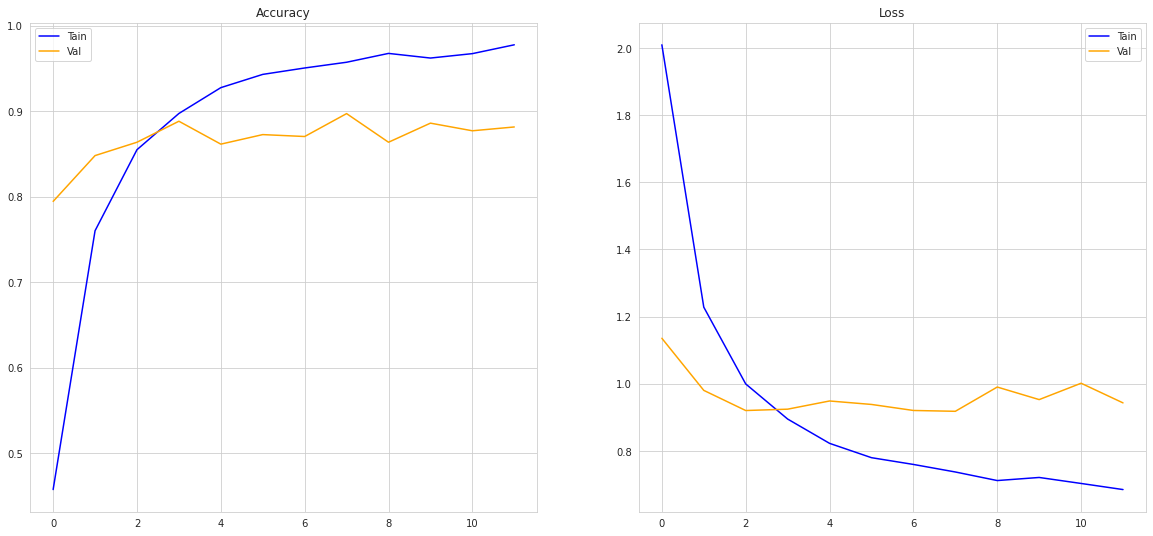

In [ ]:
# визуализируем процесс обучения
titles_ = ['Accuracy','Loss']
plt.figure(figsize=(20, 9))
k=0
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(history[0+k], label='Tain', c='b')
    plt.plot(history[2+k], label='Val', c='orange')
    plt.title(titles_[i])
    plt.grid()
    plt.legend(loc='best')
    k += 1

In [ ]:
model.eval()

y_true = np.array([])
y_preds = np.array([])

for images, lables in tqdm(val_dataloader):
    images = images.to(device)
    with torch.no_grad():
        preds = model(images).argmax(-1)
        y_true = np.append(y_true, lables.detach().cpu().numpy().ravel())
        y_preds = np.append(y_preds, preds.detach().cpu().numpy())

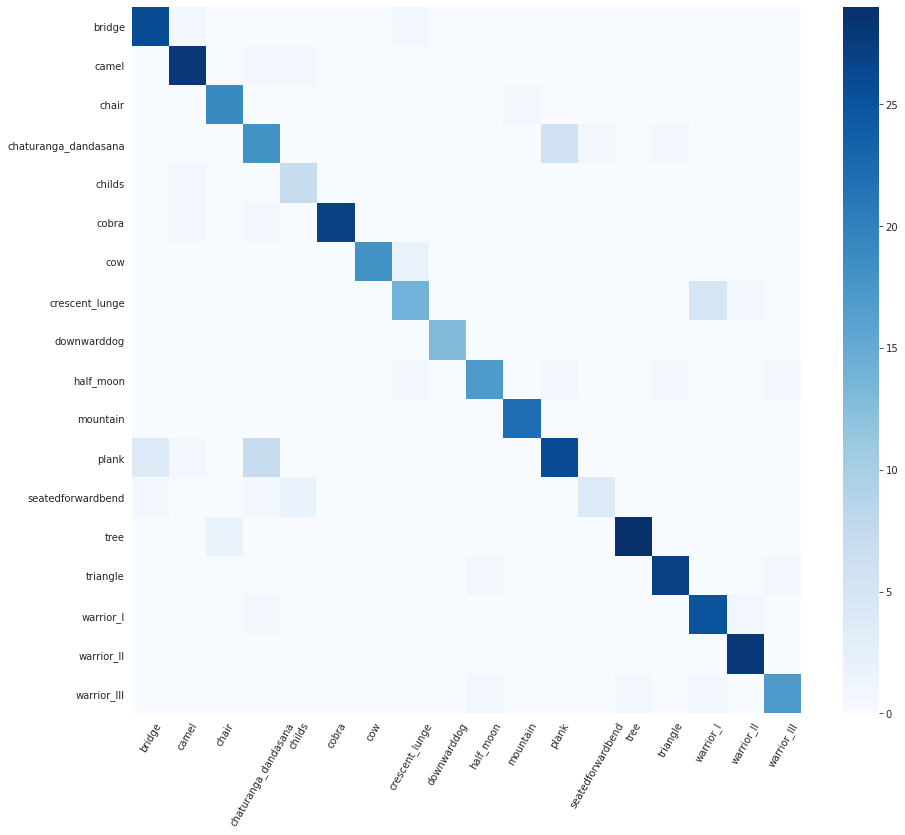

In [ ]:
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize']=15, 13
cm = confusion_matrix(y_true, y_preds)
label_encoder = val_dataset.label_encoder
g = sns.heatmap(cm, cmap = "Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, annot=False)
ax.set_title("Confusion Matrix", fontsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=60)
None

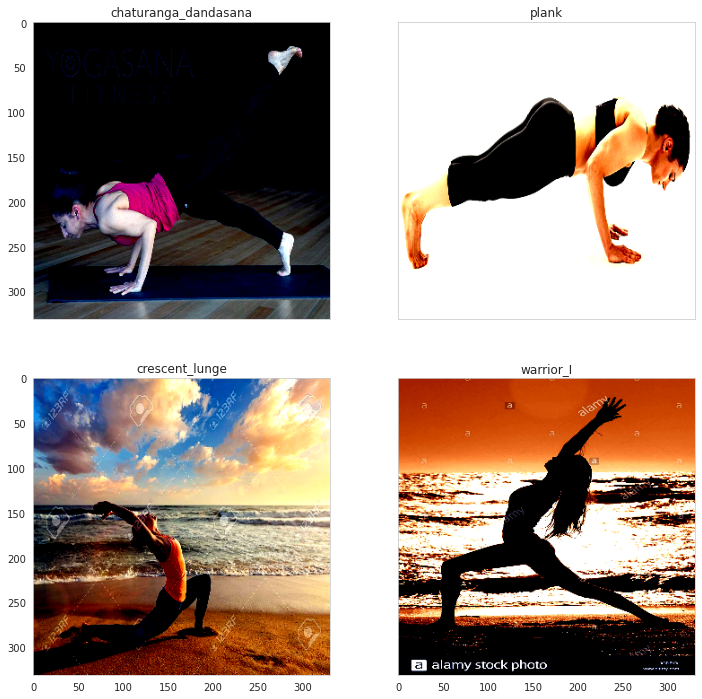

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12), \
                       sharex=True, sharey=True)
idxs = [78, 237, 161, 343]
for i, ax in enumerate(axs.flatten()):
    image_index =  idxs[i]
    im_val, label = val_dataset[image_index]
    ax.set_title(val_dataset.label_encoder.classes_[label])
    image = np.clip(im_val.permute(1, 2, 0).numpy()*std + mean, 0, 1)
    ax.imshow(image)
plt.show()

In [ ]:
# дообучим на всех данных
optimizer = torch.optim.AdamW(model.parameters(), lr=3.0e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1, verbose=True)

seed_all(31)

history = train_model(model, loss, optimizer, scheduler, scaler=None, num_epochs=6, train_all=True);

Adjusting learning rate of group 0 to 3.0000e-04.
Epoch 0/5:
Adjusting learning rate of group 0 to 3.0000e-04.
train Loss: 0.8665 Acc: 0.9133
Epoch 1/5:
Adjusting learning rate of group 0 to 3.0000e-05.
train Loss: 0.8508 Acc: 0.9143
Epoch 2/5:
Adjusting learning rate of group 0 to 3.0000e-05.
train Loss: 0.7441 Acc: 0.9573
Epoch 3/5:
Adjusting learning rate of group 0 to 3.0000e-06.
train Loss: 0.7017 Acc: 0.9709
Epoch 4/5:
Adjusting learning rate of group 0 to 3.0000e-06.
train Loss: 0.6892 Acc: 0.9758
Epoch 5/5:
Adjusting learning rate of group 0 to 3.0000e-07.
train Loss: 0.6771 Acc: 0.9790


In [ ]:
torch.save(model.state_dict(), "drive/MyDrive/pnasnet_01ep_weights.pth")

# Where to use our work?

In [ ]:
%cp '/content/drive/MyDrive/vid2.mp4' 'video.mp4'

In [ ]:
model.eval()
long_name = set(['chaturanga_dandasana'])
func = np.vectorize(lambda x: x[:x.find('_')] if x in long_name \
                                                  != -1 else x)

video_dir = 'video.mp4'
cap = cv2.VideoCapture(video_dir)
frameRate = cap.get(5) #frame rate

out = cv2.VideoWriter('output_video.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      np.round(cap.get(5)), 
                      (868, 488))
x = 0
prev_preds = np.array([])

while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if x % 3 == 0:
            image = val_transform(image=frame)['image']
            with torch.no_grad():
                img = image.unsqueeze(0).cuda()
                preds = model(img)
                preds = torch.nn.Softmax()(preds)
                preds = preds.cpu().numpy().ravel()
                prev_preds = preds
        else:
            preds = prev_preds
        x += 1
        pc = np.argsort(preds)[-3:][::-1]
        labels = all_dataset.label_encoder.inverse_transform(pc)
        labels = func(labels)

        frame = cv2.rectangle(frame, 
                              (0, 0), (260, 110), (255,255,255), -1)
        text = '{} : {:.1%} \n{} : {:.1%} \n{} : {:.1%}'.format(labels[0], preds[pc[0]],
                                                                labels[1], preds[pc[1]],
                                                                labels[2], preds[pc[2]])
        
        y0, dy = 30, 30
        for i, line in enumerate(text.split('\n')):
            y = y0 + i*dy
            frame = cv2.putText(frame, line, org=(10, y), fontFace=cv2.FONT_HERSHEY_COMPLEX,  
                          fontScale=0.7, color=(0,0,0), thickness=1, lineType=cv2.LINE_AA)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        prev_image = frame
        out.write(frame)
    else:
        break
    
cap.release()
out.release()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
